# Import Libraries

In [1]:
import os # to read the folders ( provides functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc. You first need to import the os module to interact with the underlying operating system.)
from PIL import Image # PIL stands for Python Image Library, The library provides support for various image formats including the popular JPEG and PNG formats.It also provides various image processing methods
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
print ( 'modules loaded')

/var/folders/jq/kxrl2tcj53z555vfr3_jd16w6ybq2c/T/ipykernel_7176/2269904399.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-17 15:08:08.566168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


modules loaded


# Pre-processing

create a dataframe first with 2 columns: image path and label

In [2]:
data_dir = '/Users/raniva/Desktop/Lung-and-Colon-Cancer-Classification/lung_colon_image_set'
file_paths= []
labels = []

folds= os.listdir(data_dir) # if u print folds, the result would be ['colon_image_sets','lung_image_sets']
for fold in folds :
    sub_fold_path = os.path.join(data_dir,fold) #the first iteration the sub_fold_path will be :'/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets'
    subfolds = os.listdir (sub_fold_path) #1st iter : ['colon_aca','colon_n']
    for sfold in subfolds:
        sfold_path= os.path.join (sub_fold_path,sfold)
        pic_list= os.listdir(sfold_path)
        for each_pic in pic_list:
            each_pic_path = os.path.join(sfold_path,each_pic)
            file_paths.append(each_pic_path)
            labels.append(sfold)
fseries = pd.Series(file_paths, name='file_paths')
lseries = pd.Series(labels, name='labels')

df =pd.concat([fseries,lseries],axis =1)
df

file_paths     labels
0      /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...   lung_aca
1      /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...   lung_aca
2      /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...   lung_aca
3      /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...   lung_aca
4      /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...   lung_aca
...                                                  ...        ...
24995  /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...  colon_aca
24996  /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...  colon_aca
24997  /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...  colon_aca
24998  /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...  colon_aca
24999  /Users/raniva/Desktop/Lung-and-Colon-Cancer-Cl...  colon_aca

[25000 rows x 2 columns]

In [3]:
# Split the data into train, test and validation data
train_df, ts_df = train_test_split(df,
                                   test_size= 0.2, 
                                   random_state=42,
                                   stratify= df['labels'])# to gurantee each label will be 20% test)

valid_df, test_df = train_test_split(ts_df,
                                     test_size= 0.5,
                                     random_state=42,
                                     stratify= ts_df['labels'])

## ImageDataGenerator

In [4]:
batch_size= 64
img_size= (224,224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,
                                   batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='file_paths', y_col='labels',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,
                                   batch_size= batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels',target_size= img_size, 
                                   class_mode= 'categorical', color_mode='rgb', shuffle = False,
                                   batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


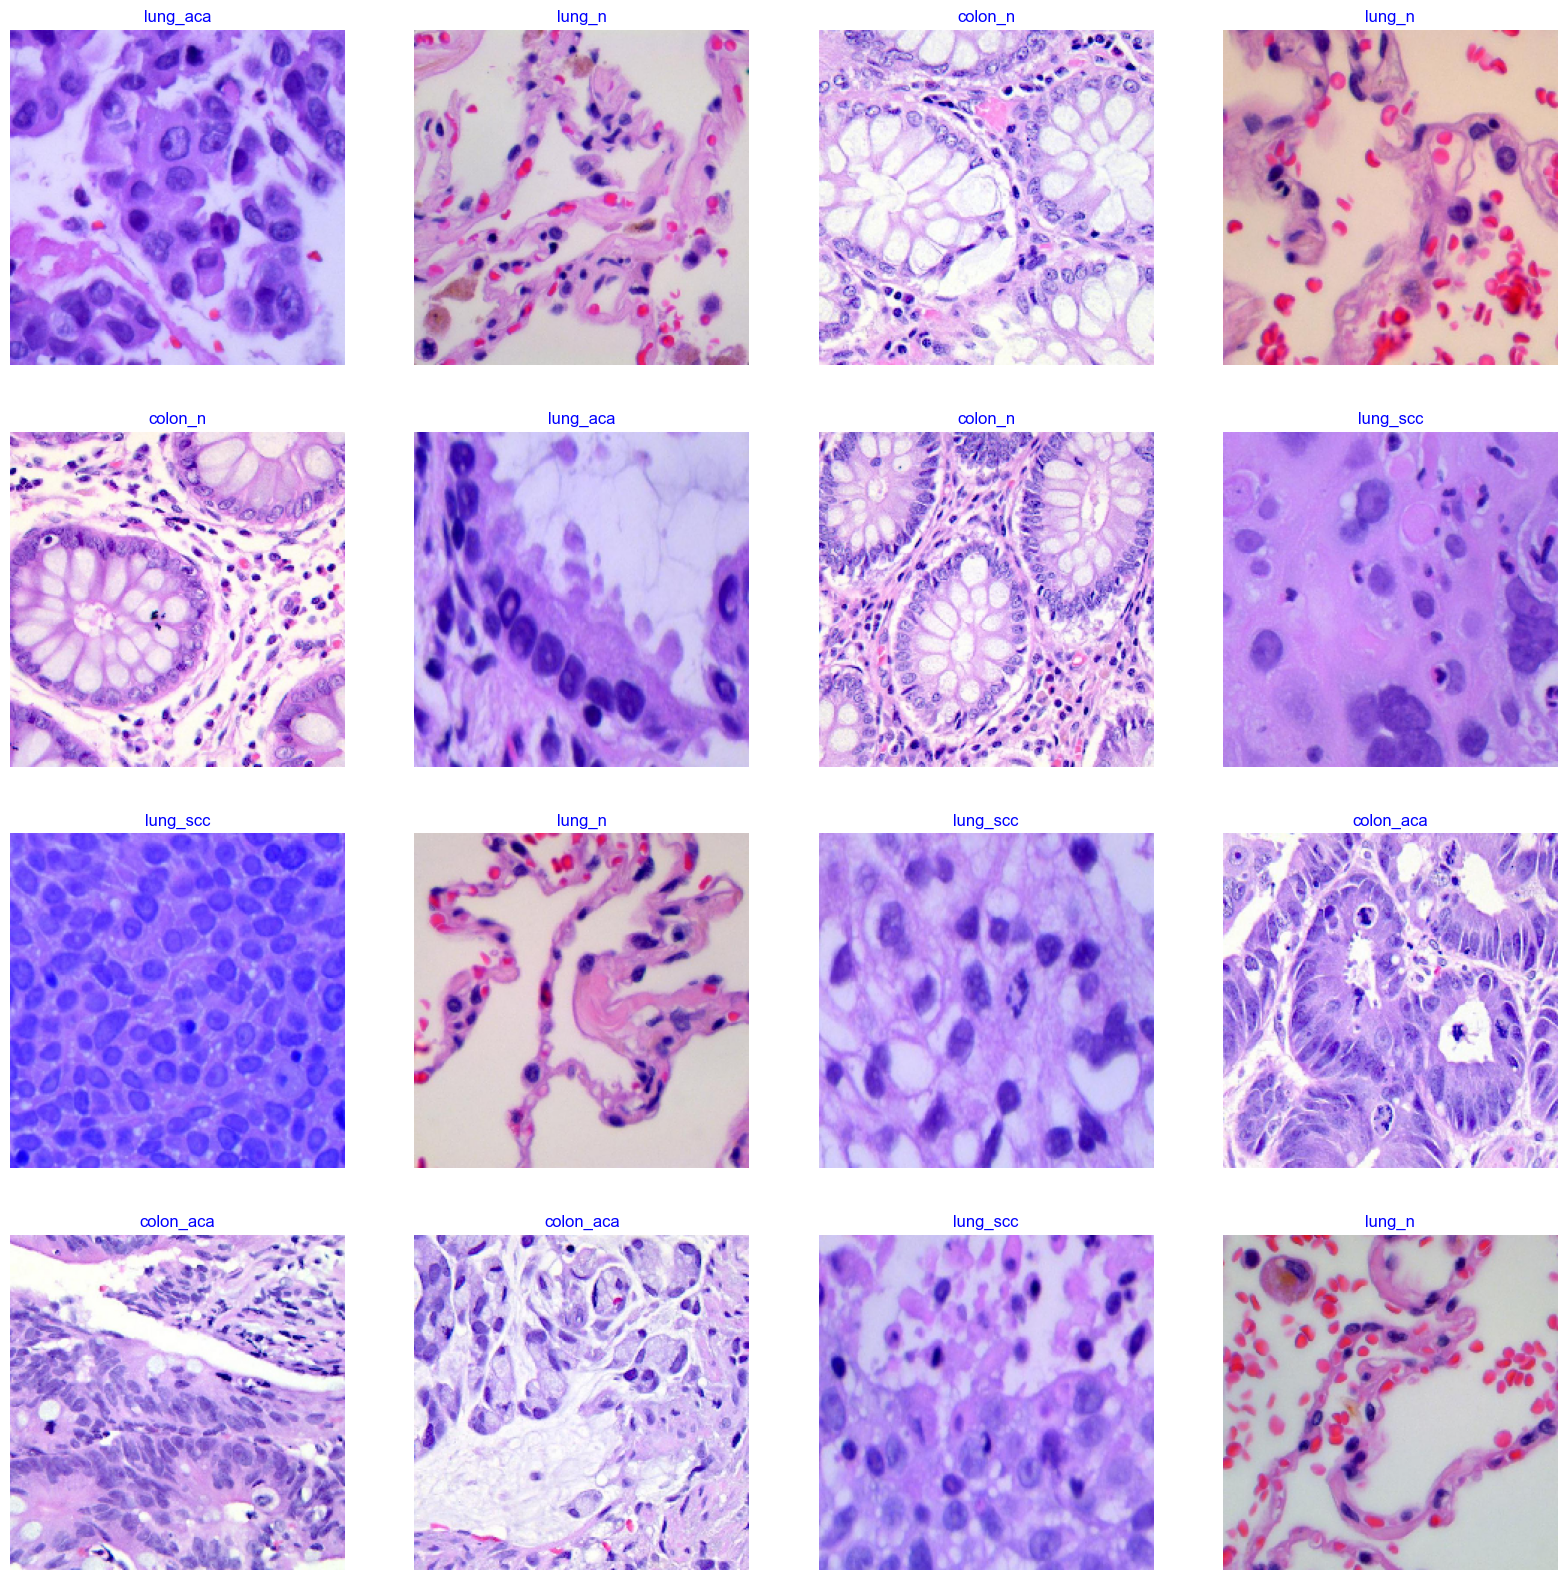

In [5]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

In [6]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy']
             )

In [ ]:
hist= model.fit(train_gen,
                epochs= 20,
                verbose= 1,
                validation_data= valid_gen,
                shuffle= False )

Epoch 1/20
105/313 [=========>....................] - ETA: 1:45:53 - loss: 6.9069 - accuracy: 0.2363

In [ ]:
# Define needed variables
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))] #[1,2,3,4,5]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score= model.evaluate(train_gen)
valid_score= model.evaluate(valid_gen)
test_score=  model.evaluate(test_gen)

In [ ]:
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Prediction

In [ ]:
preds = model.predict_generator(test_gen)
preds

In [ ]:
y_pred = np.argmax(preds, axis=1)
y_pred

In [ ]:
gen_dict= test_gen.class_indices
gen_dict

In [ ]:
classes= [gen_dict.keys()]
classes

## Confusion Matrix

In [ ]:
cm = confusion_matrix(test_gen.classes, y_pred) #(y_true, y_predicted)
cm

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): #(5,5)
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()